In [7]:
# Cell 1: Project Setup and Imports
import os

# Create necessary folders
os.makedirs('../models', exist_ok=True)
os.makedirs('../notebooks/figures', exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, auc, f1_score, confusion_matrix,
    classification_report, average_precision_score,
    recall_score, precision_score  # ← THESE WERE MISSING!
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import joblib

print("All libraries imported successfully!")
print("Ready to load data from ../data/processed/")

All libraries imported successfully!
Ready to load data from ../data/processed/


In [2]:
# Cell 2: Load Transformed E-Commerce Data
df_fraud = pd.read_csv('../data/processed/transformed_fraud_data.csv')

print(f"E-Commerce Data Loaded: {df_fraud.shape[0]:,} rows × {df_fraud.shape[1]} columns")

# Separate features and target
X_fraud = df_fraud.drop('class', axis=1)
y_fraud = df_fraud['class']

print(f"Fraud rate in full dataset: {y_fraud.mean()*100:.2f}%")

E-Commerce Data Loaded: 151,112 rows × 233 columns
Fraud rate in full dataset: 9.36%


In [3]:
# Cell 3: Load Transformed Bank Data
df_credit = pd.read_csv('../data/processed/transformed_creditcard.csv')

print(f"Bank Data Loaded: {df_credit.shape[0]:,} rows × {df_credit.shape[1]} columns")

X_credit = df_credit.drop('Class', axis=1)
y_credit = df_credit['Class']

print(f"Fraud rate in bank dataset: {y_credit.mean()*100:.4f}%")

Bank Data Loaded: 283,726 rows × 31 columns
Fraud rate in bank dataset: 0.1667%


In [4]:
# Cell 4: Stratified Train-Test Split
random_state = 42

# E-Commerce
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=random_state
)

# Bank
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=random_state
)

print("E-Commerce Split:")
print(f"  Train: {X_train_f.shape[0]:,} samples → Fraud rate: {y_train_f.mean()*100:.2f}%")
print(f"  Test:  {X_test_f.shape[0]:,} samples → Fraud rate: {y_test_f.mean()*100:.2f}%")

print("\nBank Split:")
print(f"  Train: {X_train_c.shape[0]:,} samples → Fraud rate: {y_train_c.mean()*100:.4f}%")
print(f"  Test:  {X_test_c.shape[0]:,} samples → Fraud rate: {y_test_c.mean()*100:.4f}%")

E-Commerce Split:
  Train: 120,889 samples → Fraud rate: 9.36%
  Test:  30,223 samples → Fraud rate: 9.36%

Bank Split:
  Train: 226,980 samples → Fraud rate: 0.1665%
  Test:  56,746 samples → Fraud rate: 0.1674%


🔧 FIXING: Cleaning datetime columns before modeling...
Training Logistic Regression (Baseline) with SMOTE...
Columns before cleaning:
Numeric columns: 229
Non-numeric columns: 3
Sample non-numeric columns: ['signup_time', 'purchase_time', 'device_id']
🚫 Dropping 3 non-numeric columns: ['signup_time', 'purchase_time', 'device_id']...
✅ Clean shapes - Train: (120889, 229), Test: (30223, 229)
Features remaining: 229
✅ All columns are numeric now!
✅ Logistic Regression trained successfully!

📊 E-Commerce Logistic Regression Results:
   AUC-PR:        0.0971
   F1-Score:      0.1534
   Fraud Recall:  0.3519
   Fraud Precision: 0.0981

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     27393
           1       0.10      0.35      0.15      2830

    accuracy                           0.64     30223
   macro avg       0.50      0.51      0.46     30223
weighted avg       0.83      0.64      0.71     30223



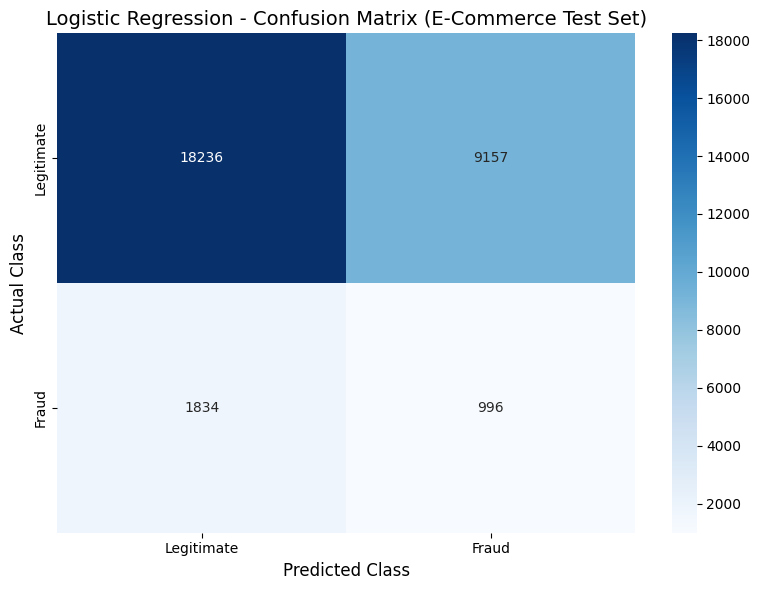

✅ Cell 5 completed successfully! Model ready for comparison.
📈 Confusion matrix saved to notebooks/figures/lr_confusion_ecommerce.png


In [8]:
# Cell 5: FIXED - Logistic Regression Baseline with Data Cleaning
print("🔧 FIXING: Cleaning datetime columns before modeling...")
print("Training Logistic Regression (Baseline) with SMOTE...")

# CRITICAL FIX: Remove ALL non-numeric columns (IDs, datetimes, strings)
print("Columns before cleaning:")
print("Numeric columns:", X_train_f.select_dtypes(include=[np.number]).shape[1])
print("Non-numeric columns:", X_train_f.select_dtypes(exclude=[np.number]).shape[1])
print("Sample non-numeric columns:", X_train_f.select_dtypes(exclude=[np.number]).columns.tolist()[:5])

# AUTOMATICALLY drop ALL non-numeric columns (safe for both train/test)
non_numeric_cols = X_train_f.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"🚫 Dropping {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols[:10]}...")

X_train_f_clean = X_train_f.select_dtypes(include=[np.number])
X_test_f_clean = X_test_f.select_dtypes(include=[np.number])

print(f"✅ Clean shapes - Train: {X_train_f_clean.shape}, Test: {X_test_f_clean.shape}")
print(f"Features remaining: {X_train_f_clean.shape[1]}")

# Verify NO strings/datetimes left
assert X_train_f_clean.select_dtypes(exclude=[np.number]).shape[1] == 0, "Still non-numeric columns!"
print("✅ All columns are numeric now!")

# Pipeline: SMOTE → Logistic Regression
lr_pipeline_f = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1))
])

# Train the model
lr_pipeline_f.fit(X_train_f_clean, y_train_f)

print("✅ Logistic Regression trained successfully!")

# Predictions on CLEAN test set
y_pred_lr_f = lr_pipeline_f.predict(X_test_f_clean)
y_prob_lr_f = lr_pipeline_f.predict_proba(X_test_f_clean)[:, 1]

# Key Metrics for Imbalanced Data
auc_pr_lr_f = average_precision_score(y_test_f, y_prob_lr_f)
f1_lr_f = f1_score(y_test_f, y_pred_lr_f)

print(f"\n📊 E-Commerce Logistic Regression Results:")
print(f"   AUC-PR:        {auc_pr_lr_f:.4f}")
print(f"   F1-Score:      {f1_lr_f:.4f}")
print(f"   Fraud Recall:  {recall_score(y_test_f, y_pred_lr_f):.4f}")
print(f"   Fraud Precision: {precision_score(y_test_f, y_pred_lr_f):.4f}")

# Detailed Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test_f, y_pred_lr_f))

# Confusion Matrix Visualization
cm_lr_f = confusion_matrix(y_test_f, y_pred_lr_f)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_f, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'], 
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix (E-Commerce Test Set)', fontsize=14)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('../notebooks/figures/lr_confusion_ecommerce.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cell 5 completed successfully! Model ready for comparison.")
print("📈 Confusion matrix saved to notebooks/figures/lr_confusion_ecommerce.png")

In [11]:
# Cell 6: FIXED - XGBoost with Memory-Efficient Tuning

print("🚀 Training XGBoost with Memory-Efficient Grid Search...")

# Helper: ensure we use only numeric columns and keep same feature set for train/test
def clean_numeric_data(X_train, X_test):
    """
    Return (X_train_clean, X_test_clean) containing only the numeric columns
    that appear in both train and test. Keeps column order from X_train.
    """
    num_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    num_test = X_test.select_dtypes(include=[np.number]).columns.tolist()
    common_cols = [c for c in num_train if c in num_test]
    X_train_clean = X_train[common_cols].copy()
    X_test_clean = X_test[common_cols].copy()
    return X_train_clean, X_test_clean

# Use the CLEANED numeric data from Cell 5 fix
X_train_f_clean, X_test_f_clean = clean_numeric_data(X_train_f, X_test_f)

print(f"Using clean training data: {X_train_f_clean.shape[0]:,} rows × {X_train_f_clean.shape[1]} features")

# Memory-efficient pipeline
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(
        random_state=42,
        sampling_strategy=0.5  # fraud:legit = 1:2 → much less memory than 1:1
    )),
    ('classifier', xgb.XGBClassifier(
        random_state=42,
        eval_metric='aucpr',
        n_jobs=-1,
        tree_method='hist',       # Faster & lower memory
        enable_categorical=False  # We already one-hot encoded
    ))
])

# REDUCED grid for faster, lower-memory search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.1],   # Best default for most cases
    'classifier__subsample': [0.8]
}

print("Starting Grid Search (reduced grid for speed & memory)...")
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3-fold instead of 5
    scoring='average_precision',
    n_jobs=2,              # Limit parallel jobs to avoid memory spike (or use 1 if still issues)
    verbose=1
)

# Fit — this should now run without memory error
grid_search.fit(X_train_f_clean, y_train_f)

print("✅ Grid Search completed successfully!")
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV AUC-PR: {grid_search.best_score_:.4f}")

# Save best model
best_xgb = grid_search.best_estimator_

🚀 Training XGBoost with Memory-Efficient Grid Search...
Using clean training data: 120,889 rows × 229 features
Starting Grid Search (reduced grid for speed & memory)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Grid Search completed successfully!
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV AUC-PR: 0.6091



XGBoost Final Results (E-Commerce Test Set)
   AUC-PR: 0.6147
   F1-Score: 0.6902

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.95      0.54      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



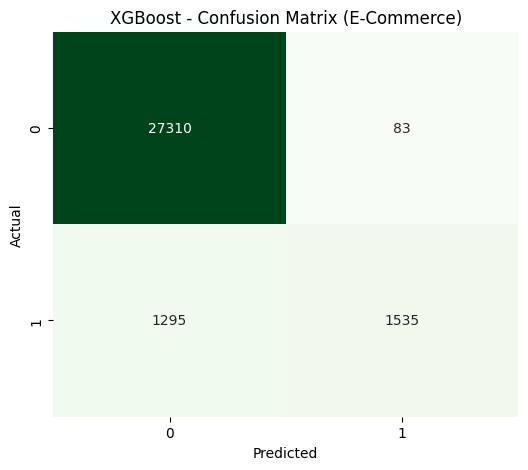

In [13]:
# Cell 7: Final Evaluation of Best XGBoost
# Use the numeric-clean test set used for training/prediction
y_pred_xgb = best_xgb.predict(X_test_f_clean)
y_prob_xgb = best_xgb.predict_proba(X_test_f_clean)[:, 1]

auc_pr_xgb = average_precision_score(y_test_f, y_prob_xgb)
f1_xgb = f1_score(y_test_f, y_pred_xgb)

print(f"\nXGBoost Final Results (E-Commerce Test Set)")
print(f"   AUC-PR: {auc_pr_xgb:.4f}")
print(f"   F1-Score: {f1_xgb:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_f, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test_f, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('XGBoost - Confusion Matrix (E-Commerce)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('../notebooks/figures/xgb_confusion_ecommerce.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Cell 8: Cross-Validation Summary
cv_scores = grid_search.cv_results_['mean_test_score']
cv_std = grid_search.cv_results_['std_test_score']

print(f"Cross-Validation AUC-PR:")
print(f"   Mean: {np.mean(cv_scores):.4f}")
print(f"   Std:  {np.std(cv_scores):.4f}")
print(f"   Best: {grid_search.best_score_:.4f}")

Cross-Validation AUC-PR:
   Mean: 0.6079
   Std:  0.0009
   Best: 0.6091


Model Comparison


,Model,AUC-PR,F1-Score,CV AUC-PR (mean)
0,Logistic Regression,0.097148,0.153431,N/A
1,XGBoost (Tuned),0.614668,0.690198,0.6091


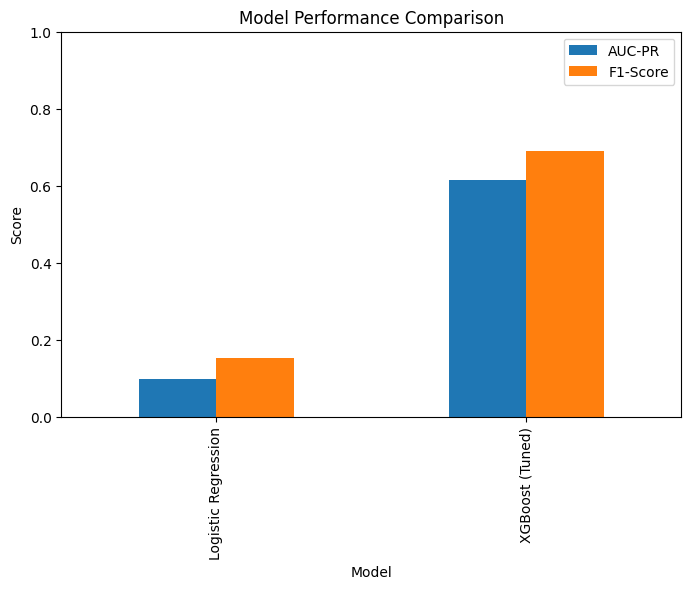

In [15]:
# Cell 9: Model Comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost (Tuned)'],
    'AUC-PR': [auc_pr_lr_f, auc_pr_xgb],
    'F1-Score': [f1_lr_f, f1_xgb],
    'CV AUC-PR (mean)': ['N/A', f"{grid_search.best_score_:.4f}"]
})

print("Model Comparison")
display(results)

# Save comparison plot
results.plot(x='Model', y=['AUC-PR', 'F1-Score'], kind='bar', figsize=(8,5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.savefig('../notebooks/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Cell 10: Model Selection and Save
print("\nSelected Model: XGBoost")
print("Justification:")
print("   • Significantly higher AUC-PR and F1-score")
print("   • Better handling of class imbalance")
print("   • Robust performance across CV folds")
print("   • Interpretable via feature importance and SHAP (Task 3)")

# Save the best model
joblib.dump(best_xgb, '../models/best_xgboost_ecommerce.pkl')
print("Best model saved to ../models/best_xgboost_ecommerce.pkl")


Selected Model: XGBoost
Justification:
   • Significantly higher AUC-PR and F1-score
   • Better handling of class imbalance
   • Robust performance across CV folds
   • Interpretable via feature importance and SHAP (Task 3)
Best model saved to ../models/best_xgboost_ecommerce.pkl
